In [68]:
# %%writefile src/data_loading.py
"""
Module: data_loading.py
Contains functions to load and prepare the raw data.
"""

import pandas as pd
import json
import logging
import sys

def load_data(csv_path, json_path, participant_id='P0001', debug=False):
    """
    Loads CSV and JSON data with full participant merge.
    
    Parameters:
      csv_path (str): Path to the CSV file.
      json_path (str): Path to the JSON file with participant info.
      participant_id (str): Default participant ID if not found.
      debug (bool): If True, provides additional logging.
      
    Returns:
      pd.DataFrame: Merged data.
    """
    try:
        data = pd.read_csv(csv_path)
        logging.info(f"Loaded data from {csv_path} with shape {data.shape}")
    except Exception as e:
        logging.error(f"CSV load error: {e}")
        sys.exit(1)
    
    # Load and merge participant info
    try:
        with open(json_path, "r") as f:
            participant_info = json.load(f)
        
        # Handle different JSON structures: if it's a dict with a key for participant info
        # or a list of participants.
        if isinstance(participant_info, dict):
            # Check if the key 'participant_id' exists at the top level
            if "participant_id" not in participant_info:
                # Optionally, if participant_info contains a nested structure,
                # adjust this part accordingly.
                participant_info["participant_id"] = participant_id
            # Convert dict to DataFrame (assumes each key is a column)
            participant_df = pd.DataFrame([participant_info])
        elif isinstance(participant_info, list):
            participant_df = pd.json_normalize(participant_info)
            if 'participant_id' not in participant_df.columns:
                participant_df['participant_id'] = participant_id
        else:
            logging.error("Unexpected JSON format for participant info.")
            sys.exit(1)
        
        # Merge on participant_id; if CSV data doesn't have this column, add it with the default.
        if 'participant_id' not in data.columns:
            data['participant_id'] = participant_id
        
        data = data.merge(participant_df, on='participant_id', how='left')
        logging.info(f"Merged participant data with columns: {list(participant_df.columns)}")
    except Exception as e:
        logging.error(f"JSON merge error: {e}")
        sys.exit(1)
    
    return data



def prepare_joint_features(data, debug=False):
    """Prepares joint features (e.g., power ratios, range-of-motion features)."""
    new_cols = []
    # Example: compute a joint power ratio feature
    joints = ['elbow', 'knee']
    for joint in joints:
        left_col = f"L_{joint}_power"
        right_col = f"R_{joint}_power"
        if left_col in data.columns and right_col in data.columns:
            ratio_col = f"{joint}_power_ratio"
            data[ratio_col] = data[left_col] / (data[right_col] + 1e-6)
            new_cols.append(ratio_col)
            logging.info(f"Created power ratio feature: {ratio_col}")
        else:
            logging.warning(f"Columns for {joint} not found; skipping power ratio.")
    
    # Additional joint feature calculations can be added here...
    
    return data

def feature_engineering(data, window_size=5, debug=False):
    """Performs additional feature engineering."""
    new_cols = []
    if 'continuous_frame_time' in data.columns:
        data['time_since_start'] = data['continuous_frame_time'] - data['continuous_frame_time'].min()
        new_cols.append('time_since_start')
    else:
        logging.error("continuous_frame_time column missing")
        sys.exit(1)
    
    # Fill missing ball-related and motion columns if they exist
    ball_cols = ['ball_speed', 'ball_velocity_x', 'ball_velocity_y', 'ball_velocity_z']
    for col in ball_cols:
        if col in data.columns:
            data[col] = data[col].fillna(0)
    motion_cols = ['dx', 'dy', 'dz']
    for col in motion_cols:
        if col in data.columns:
            data[col] = data[col].fillna(method='ffill').fillna(0)
            
    logging.info("Feature engineering completed.")
    return data

In [69]:
# %%writefile src/advanced_features.py
"""
Module: advanced_features.py
Contains advanced feature engineering functions, including computation of joint angles,
power ratios, range-of-motion (ROM) features, and injury risk.
"""

import numpy as np
import pandas as pd
import logging
import sys

def calculate_joint_angles(df, debug=False):
    """
    Computes joint angles based on vector calculations.
    
    Parameters:
      df (pd.DataFrame): Input DataFrame with joint coordinate columns.
      debug (bool): If True, logs additional information.
      
    Returns:
      pd.DataFrame: DataFrame with computed joint angle columns.
    """
    # Define joints and their coordinate columns for left and right sides.
    angle_definitions = {
        'SHOULDER': {'left': ['L_HIP', 'L_SHOULDER', 'L_ELBOW'],
                     'right': ['R_HIP', 'R_SHOULDER', 'R_ELBOW']},
        # Add more joint definitions as required...
    }
    
    for joint, sides in angle_definitions.items():
        for side, cols in sides.items():
            # Check if all required columns exist
            if all(col in df.columns for col in cols):
                # Dummy vector calculation (replace with actual vector math)
                # For example: compute angle using arctan2 of vector differences
                df[f"{side.upper()}_{joint}_angle"] = np.arctan2(
                    df[cols[2]] - df[cols[1]],
                    df[cols[1]] - df[cols[0]]
                )
                if debug:
                    logging.info(f"Calculated {side.upper()}_{joint}_angle using columns {cols}")
            else:
                logging.warning(f"Missing columns for {side} {joint}; skipping angle calculation.")
    return df

def prepare_joint_features(data, debug=False):
    """
    Prepares joint features including:
      - Calculation of joint angles.
      - Computation of power ratios.
      - Range-of-Motion (ROM) features per joint.
    
    Parameters:
      data (pd.DataFrame): Input DataFrame.
      debug (bool): If True, logs additional information.
      
    Returns:
      pd.DataFrame: DataFrame with new joint features.
    """
    # First, calculate joint angles
    data = calculate_joint_angles(data, debug)
    
    # Compute power ratios for specified joints (example with elbow, knee, ankle)
    for joint in ['elbow', 'knee', 'ankle']:
        left_power = f"L_{joint.upper()}_ongoing_power" 
        right_power = f"R_{joint.upper()}_ongoing_power"
        ratio_col = f"{joint}_power_ratio"
        if left_power in data.columns and right_power in data.columns:
            data[ratio_col] = data[left_power] / (data[right_power] + 1e-6)
            if debug:
                logging.info(f"Created power ratio feature: {ratio_col}")
        else:
            logging.warning(f"Columns {left_power} or {right_power} not found; skipping {joint} power ratio.")
    
    # Add ROM calculations (example for knee)
    rom_joints = {'KNEE': {'min': 120, 'max': 135}}
    for joint, thresholds in rom_joints.items():
        for side in ['L', 'R']:
            angle_col = f"{side}_{joint}_angle"
            rom_col = f"{side}_{joint}_ROM"
            if angle_col in data.columns:
                # Compute range of motion per trial using groupby on trial_id
                data[rom_col] = data.groupby('trial_id')[angle_col].transform(lambda x: x.max() - x.min())
                if debug:
                    logging.info(f"Computed ROM for {rom_col}")
            else:
                logging.warning(f"Column {angle_col} not found; cannot compute ROM for {side} {joint}.")
    
    return data

def compute_aggregated_features(data, debug=False):
    """
    Computes aggregated joint features including joint energy, joint power,
    and energy acceleration.
    """
    # Compute joint_energy if not already present.
    energy_cols = [col for col in data.columns if "_energy" in col 
                   and "by_trial" not in col and "overall" not in col]
    if energy_cols:
        data['joint_energy'] = data[energy_cols].sum(axis=1)
        if debug:
            logging.info(f"Computed joint_energy using columns: {energy_cols}")
    else:
        logging.warning("No joint energy columns found to compute 'joint_energy'.")
    
    # Compute joint_power if not already present.
    power_cols = [col for col in data.columns if "_ongoing_power" in col]
    if power_cols:
        data['joint_power'] = data[power_cols].sum(axis=1)
        if debug:
            logging.info(f"Computed joint_power using columns: {power_cols}")
    else:
        logging.warning("No joint ongoing power columns found to compute 'joint_power'.")
    
    # Compute energy_acceleration if continuous_frame_time is available.
    if 'continuous_frame_time' in data.columns and 'joint_energy' in data.columns:
        time_diff = data['continuous_frame_time'].diff().replace(0, 1e-6)
        data['energy_acceleration'] = data['joint_energy'].diff() / time_diff
        data['energy_acceleration'] = data['energy_acceleration'].replace([np.inf, -np.inf], np.nan)
        if debug:
            logging.info("Computed energy_acceleration as derivative of joint_energy.")
    else:
        logging.warning("Missing continuous_frame_time or joint_energy for energy_acceleration calculation.")
    
    # (Optional) Rename anthropometric columns if available.
    if 'height_in_meters' in data.columns and 'weight__in_kg' in data.columns:
        data['player_height_in_meters'] = data['height_in_meters']
        data['player_weight__in_kg'] = data['weight__in_kg']
        data.drop(['height_in_meters', 'weight__in_kg'], axis=1, inplace=True, errors='ignore')
        if debug:
            logging.info("Renamed anthropometric columns.")
    
    return data

def compute_injury_risk(data, debug=False):
    """
    Computes an injury risk column if it doesn't exist.
    Here, injury risk is computed simply by using the median of 'by_trial_exhaustion_score'.
    """
    if 'injury_risk' not in data.columns:
        if 'by_trial_exhaustion_score' in data.columns:
            median_val = data['by_trial_exhaustion_score'].median()
            data['injury_risk'] = (data['by_trial_exhaustion_score'] > median_val).astype(int)
            if debug:
                logging.info("Computed injury_risk using median threshold.")
        else:
            logging.error("Neither 'injury_risk' nor 'by_trial_exhaustion_score' exist in the data!")
            sys.exit(1)
    else:
        if debug:
            logging.info("injury_risk column already exists.")
    return data


In [70]:
# %%writefile src/preprocessing.py
"""
Module: preprocessing.py
Contains functions for train/test splitting, scaling, and sequence generation.
"""

import numpy as np
import pandas as pd
import logging
from sklearn.preprocessing import StandardScaler

def temporal_train_test_split(data, test_size=0.2):
    """Time-based train-test split."""
    split_idx = int(len(data) * (1 - test_size))
    train_data = data.iloc[:split_idx].copy()
    test_data = data.iloc[split_idx:].copy()
    logging.info(f"Performed temporal train-test split with test size = {test_size}")
    logging.info(f"Train data shape: {train_data.shape}, Test data shape: {test_data.shape}")
    return train_data, test_data

def scale_features(X_train, X_test):
    """Scales features using StandardScaler."""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    logging.info("Features have been scaled using StandardScaler.")
    return X_train_scaled, X_test_scaled, scaler

def create_sequences(X, y, timesteps):
    """
    Creates LSTM sequences from a dataset.
    Parameters:
      - X: Array of features.
      - y: Target array.
      - timesteps: Number of past observations to include.
    Returns:
      - X_seq, y_seq: Arrays ready for LSTM input.
    """
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i-timesteps:i])
        y_seq.append(y[i])
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    logging.info(f"Created LSTM sequences: {X_seq.shape}, {y_seq.shape}")
    return X_seq, y_seq

In [71]:
# %%writefile src/training.py
"""
Module: training.py
Contains functions for training different models.
"""

import logging
import sys
import numpy as np
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
# from preprocessing import create_sequences, scale_features

def train_exhaustion_model(train_data, test_data, features, timesteps, 
                           epochs=50, batch_size=32, early_stop_patience=5,
                           num_lstm_layers=1, lstm_units=64, dropout_rate=0.2,
                           dense_units=1, dense_activation=None):
    """
    Trains an LSTM-based model for exhaustion (regression).

    Added validation steps to check that the required feature columns and target
    column ('by_trial_exhaustion_score') exist in the input train and test datasets.
    """
    import logging
    from sklearn.preprocessing import StandardScaler
    from tensorflow.keras import Input, Sequential
    from tensorflow.keras.layers import LSTM, Dropout, Dense
    from tensorflow.keras.callbacks import EarlyStopping
    from preprocessing import create_sequences, scale_features

    # Validate that required features exist in train_data
    missing_features_train = [feat for feat in features if feat not in train_data.columns]
    if missing_features_train:
        logging.error(f"Missing required features in training data: {missing_features_train}")
        raise KeyError(f"Missing features in training data: {missing_features_train}")

    if 'by_trial_exhaustion_score' not in train_data.columns:
        logging.error("Target column 'by_trial_exhaustion_score' is missing from training data.")
        raise KeyError("Missing target column: 'by_trial_exhaustion_score'")

    # Validate that required features exist in test_data
    missing_features_test = [feat for feat in features if feat not in test_data.columns]
    if missing_features_test:
        logging.error(f"Missing required features in test data: {missing_features_test}")
        raise KeyError(f"Missing features in test data: {missing_features_test}")

    if 'by_trial_exhaustion_score' not in test_data.columns:
        logging.error("Target column 'by_trial_exhaustion_score' is missing from test data.")
        raise KeyError("Missing target column: 'by_trial_exhaustion_score'")

    # Extract features and target arrays
    X_train = train_data[features].values
    y_train = train_data['by_trial_exhaustion_score'].values
    X_test = test_data[features].values
    y_test = test_data['by_trial_exhaustion_score'].values

    # Scale the features
    X_train_scaled, X_test_scaled, scaler_exhaustion = scale_features(X_train, X_test)
    
    # Scale the target separately
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1))
    
    # Create LSTM sequences for training and validation
    X_lstm, y_lstm = create_sequences(X_train_scaled, y_train_scaled, timesteps)
    X_lstm_val, y_lstm_val = create_sequences(X_test_scaled, y_test_scaled, timesteps)
    
    # Build the model
    model = Sequential()
    model.add(Input(shape=(X_lstm.shape[1], X_lstm.shape[2])))
    for i in range(num_lstm_layers):
        return_seq = (i < num_lstm_layers - 1)
        model.add(LSTM(lstm_units, return_sequences=return_seq))
        model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation=dense_activation))
    
    model.compile(optimizer='adam', loss='mse')
    early_stop = EarlyStopping(monitor='val_loss', patience=early_stop_patience)
    
    logging.info("Training exhaustion model...")
    model.fit(X_lstm, y_lstm, epochs=epochs, batch_size=batch_size,
              validation_data=(X_lstm_val, y_lstm_val), callbacks=[early_stop])
    
    return model, scaler_exhaustion, target_scaler, X_lstm_val, y_lstm_val

def train_injury_model(train_data, test_data, features, timesteps,
                       epochs=50, batch_size=32,
                       num_lstm_layers=1, lstm_units=64, dropout_rate=0.2,
                       dense_units=1, dense_activation='sigmoid'):
    """
    Trains an LSTM-based model for injury risk (classification).
    """
    X_train = train_data[features].values
    y_train = train_data['injury_risk'].values
    X_test = test_data[features].values
    y_test = test_data['injury_risk'].values

    X_train_scaled, X_test_scaled, scaler_injury = scale_features(X_train, X_test)
    X_lstm, y_lstm = create_sequences(X_train_scaled, y_train, timesteps)
    X_lstm_val, y_lstm_val = create_sequences(X_test_scaled, y_test, timesteps)
    
    model = Sequential()
    model.add(Input(shape=(X_lstm.shape[1], X_lstm.shape[2])))
    for i in range(num_lstm_layers):
        return_seq = (i < num_lstm_layers - 1)
        model.add(LSTM(lstm_units, return_sequences=return_seq))
        model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation=dense_activation))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    logging.info("Training injury risk model...")
    model.fit(X_lstm, y_lstm, epochs=epochs, batch_size=batch_size, 
              validation_data=(X_lstm_val, y_lstm_val))
    
    return model, scaler_injury, X_lstm_val, y_lstm_val

# Note: You can add a similar function for training joint-specific models.

In [75]:
# %%writefile src/training.py
"""
Module: training.py
Contains functions for training different models.
"""

import logging
import sys
import numpy as np
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
# from preprocessing import create_sequences, scale_features

def train_exhaustion_model(train_data, test_data, features, timesteps, 
                           epochs=50, batch_size=32, early_stop_patience=5,
                           num_lstm_layers=1, lstm_units=64, dropout_rate=0.2,
                           dense_units=1, dense_activation=None):
    """
    Trains an LSTM-based model for exhaustion (regression).
    """
    # [Existing validation and scaling code...]
    
    # Validate required features...
    missing_features_train = [feat for feat in features if feat not in train_data.columns]
    if missing_features_train:
        logging.error(f"Missing required features in training data: {missing_features_train}")
        raise KeyError(f"Missing features in training data: {missing_features_train}")
    if 'by_trial_exhaustion_score' not in train_data.columns:
        logging.error("Target 'by_trial_exhaustion_score' missing from training data.")
        raise KeyError("Missing target column: 'by_trial_exhaustion_score'")
    missing_features_test = [feat for feat in features if feat not in test_data.columns]
    if missing_features_test:
        logging.error(f"Missing required features in test data: {missing_features_test}")
        raise KeyError(f"Missing features in test data: {missing_features_test}")
    if 'by_trial_exhaustion_score' not in test_data.columns:
        logging.error("Target 'by_trial_exhaustion_score' missing from test data.")
        raise KeyError("Missing target column: 'by_trial_exhaustion_score'")
    
    # Extract features and target arrays
    X_train = train_data[features].values
    y_train = train_data['by_trial_exhaustion_score'].values
    X_test = test_data[features].values
    y_test = test_data['by_trial_exhaustion_score'].values

    # Scale features and target
    X_train_scaled, X_test_scaled, scaler_exhaustion = scale_features(X_train, X_test)
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1))
    
    # Create LSTM sequences for training and validation
    X_lstm, y_lstm = create_sequences(X_train_scaled, y_train_scaled, timesteps)
    X_lstm_val, y_lstm_val = create_sequences(X_test_scaled, y_test_scaled, timesteps)
    
    # Build the LSTM model
    model = Sequential()
    model.add(Input(shape=(X_lstm.shape[1], X_lstm.shape[2])))
    for i in range(num_lstm_layers):
        return_seq = (i < num_lstm_layers - 1)
        model.add(LSTM(lstm_units, return_sequences=return_seq))
        model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation=dense_activation))
    
    model.compile(optimizer='adam', loss='mse')
    early_stop = EarlyStopping(monitor='val_loss', patience=early_stop_patience)
    
    logging.info("Training exhaustion model...")
    model.fit(X_lstm, y_lstm, epochs=epochs, batch_size=batch_size,
              validation_data=(X_lstm_val, y_lstm_val), callbacks=[early_stop])
    
    return model, scaler_exhaustion, target_scaler, X_lstm_val, y_lstm_val

def train_injury_model(train_data, test_data, features, timesteps,
                       epochs=50, batch_size=32,
                       num_lstm_layers=1, lstm_units=64, dropout_rate=0.2,
                       dense_units=1, dense_activation='sigmoid'):
    """
    Trains an LSTM-based model for injury risk (classification).
    """

    X_train = train_data[features].values
    y_train = train_data['injury_risk'].values
    X_test = test_data[features].values
    y_test = test_data['injury_risk'].values

    X_train_scaled, X_test_scaled, scaler_injury = scale_features(X_train, X_test)
    X_lstm, y_lstm = create_sequences(X_train_scaled, y_train, timesteps)
    X_lstm_val, y_lstm_val = create_sequences(X_test_scaled, y_test, timesteps)
    
    model = Sequential()
    model.add(Input(shape=(X_lstm.shape[1], X_lstm.shape[2])))
    for i in range(num_lstm_layers):
        return_seq = (i < num_lstm_layers - 1)
        model.add(LSTM(lstm_units, return_sequences=return_seq))
        model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation=dense_activation))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    logging.info("Training injury risk model...")
    model.fit(X_lstm, y_lstm, epochs=epochs, batch_size=batch_size, 
              validation_data=(X_lstm_val, y_lstm_val))
    
    return model, scaler_injury, X_lstm_val, y_lstm_val

def train_joint_models(train_data, test_data, joints, timesteps, features_dir, 
                       epochs=50, batch_size=32,
                       num_lstm_layers=1, lstm_units=64, dropout_rate=0.2,
                       dense_units=1, dense_activation='sigmoid'):
    """
    Trains separate models for each joint injury risk.
    
    Parameters:
      train_data, test_data: DataFrames for training and testing.
      joints (list): List of joint names (e.g., ['ANKLE', 'WRIST', 'ELBOW']).
      timesteps (int): Number of timesteps for LSTM sequences.
      features_dir (str): Directory to load joint-specific feature lists.
      Other parameters control the model architecture and training.
      
    Returns:
      dict: A dictionary mapping joint targets to their model details.
    """
    joint_models = {}
    for joint in joints:
        for side in ['L', 'R']:
            target = f"{side}_{joint}_injury_risk"
            # Load joint-specific features; here we assume a helper function exists.
            # For now, we simulate by using a pre-determined list (could be read from file).
            features = [f"feature_{joint.lower()}_{side.lower()}", 'joint_power', 'joint_energy']
            # Validate that required features exist
            missing_features = [feat for feat in features if feat not in train_data.columns]
            if missing_features:
                logging.warning(f"Missing features {missing_features} for {target}; skipping training.")
                continue
            # Extract features and target arrays
            X_train = train_data[features].values
            y_train = train_data[target].values if target in train_data.columns else np.zeros(len(train_data))
            X_test = test_data[features].values
            y_test = test_data[target].values if target in test_data.columns else np.zeros(len(test_data))
            
            # Scale features
            X_train_scaled, X_test_scaled, scaler_joint = scale_features(X_train, X_test)
            X_lstm, y_lstm = create_sequences(X_train_scaled, y_train, timesteps)
            X_lstm_val, y_lstm_val = create_sequences(X_test_scaled, y_test, timesteps)
            
            # Build model
            model = Sequential()
            model.add(Input(shape=(X_lstm.shape[1], X_lstm.shape[2])))
            for i in range(num_lstm_layers):
                return_seq = (i < num_lstm_layers - 1)
                model.add(LSTM(lstm_units, return_sequences=return_seq))
                model.add(Dropout(dropout_rate))
            model.add(Dense(dense_units, activation=dense_activation))
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            
            logging.info(f"Training joint model for {target}...")
            model.fit(X_lstm, y_lstm, epochs=epochs, batch_size=batch_size, 
                      validation_data=(X_lstm_val, y_lstm_val))
            
            joint_models[target] = {
                'model': model,
                'scaler': scaler_joint,
                'features': features
            }
    return joint_models


In [76]:
# %%writefile src/inference.py
"""
Module: inference.py
Contains functions for forecasting and plotting predictions (inference stage).
"""

import numpy as np
import matplotlib.pyplot as plt
# from preprocessing import create_sequences

def forecast_and_plot_exhaustion(model, test_data, forecast_features, scaler_exhaustion, target_scaler, timesteps, future_steps=0, title="Exhaustion Forecast"):
    """
    Forecasts exhaustion scores using the trained model and plots the results.
    """
    X_forecast = test_data[forecast_features].values
    X_forecast_scaled = scaler_exhaustion.transform(X_forecast)
    X_seq, _ = create_sequences(X_forecast_scaled, np.zeros(len(X_forecast_scaled)), timesteps)

    predictions_scaled = model.predict(X_seq)
    predictions = target_scaler.inverse_transform(predictions_scaled)
    
    forecast_predictions_inv = None
    if future_steps > 0:
        current_sequence = X_seq[-1].copy()
        forecast_predictions = []
        for _ in range(future_steps):
            next_pred = model.predict(current_sequence.reshape(1, timesteps, current_sequence.shape[1]))
            forecast_predictions.append(next_pred[0, 0])
            new_row = current_sequence[-1, :].copy()
            current_sequence = np.vstack([current_sequence[1:], new_row])
        forecast_predictions = np.array(forecast_predictions).reshape(-1, 1)
        forecast_predictions_inv = target_scaler.inverse_transform(forecast_predictions)
    
    actual = test_data['by_trial_exhaustion_score'].values
    plt.figure(figsize=(10, 6))
    plt.plot(range(timesteps, len(actual)), actual[timesteps:], color='red', label='Actual')
    plt.plot(range(timesteps, len(actual)), predictions, color='blue', label='Predicted')
    if forecast_predictions_inv is not None:
        future_x = list(range(len(actual), len(actual) + future_steps))
        plt.plot(future_x, forecast_predictions_inv, color='green', linestyle='--', label='Forecast')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Exhaustion Score')
    plt.legend()
    plt.show()

def forecast_and_plot_injury(model, test_data, forecast_features, scaler_injury, timesteps, future_steps=0, title="Injury Risk Forecast"):
    """
    Forecasts injury risk using the trained model and plots the predictions.
    """
    X_forecast = test_data[forecast_features].values
    X_forecast_scaled = scaler_injury.transform(X_forecast)
    X_seq, _ = create_sequences(X_forecast_scaled, np.zeros(len(X_forecast_scaled)), timesteps)
    predictions_prob = model.predict(X_seq)
    
    actual = test_data['injury_risk'].values
    plt.figure(figsize=(10, 6))
    plt.plot(range(timesteps, len(actual)), actual[timesteps:], color='red', label='Actual')
    plt.plot(range(timesteps, len(actual)), predictions_prob, color='blue', label='Predicted Probability')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Injury Risk')
    plt.legend()
    plt.show()

# Similarly, add functions for joint-specific inference if needed.

In [77]:
# %%writefile src/results.py
"""
Module: results.py
Contains functions to summarize and save the model evaluation results.
"""

import pandas as pd
import logging
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score

def summarize_exhaustion_model(model, X_val, y_val, target_scaler):
    preds_scaled = model.predict(X_val)
    preds = target_scaler.inverse_transform(preds_scaled)
    y_true = target_scaler.inverse_transform(y_val)
    mse = mean_squared_error(y_true, preds)
    mae = mean_absolute_error(y_true, preds)
    r2 = r2_score(y_true, preds)
    return {"MSE": mse, "MAE": mae, "R2 Score": r2}

def summarize_classification_model(model, X_val, y_val):
    preds_prob = model.predict(X_val)
    preds_class = (preds_prob >= 0.5).astype(int)
    accuracy = accuracy_score(y_val, preds_class)
    precision = precision_score(y_val, preds_class, zero_division=0)
    recall = recall_score(y_val, preds_class, zero_division=0)
    f1 = f1_score(y_val, preds_class, zero_division=0)
    return {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}

def summarize_all_models(exh_metrics, injury_metrics, joint_metrics, output_file):
    summary_data = []
    summary_data.append({
        "Model": "Exhaustion Model",
        "Type": "Regression",
        **exh_metrics,
        "Accuracy": None,
        "Precision": None,
        "Recall": None,
        "F1 Score": None,
    })
    summary_data.append({
        "Model": "Injury Model",
        "Type": "Classification",
        "MSE": None,
        "MAE": None,
        "R2 Score": None,
        **injury_metrics,
    })
    for jm in joint_metrics:
        summary_data.append(jm)
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv(output_file, index=False)
    logging.info(f"Saved model summary dataframe to {output_file}")
    return summary_df

INFO: Loaded data from ../../data/processed/final_granular_dataset.csv with shape (16047, 214)
INFO: Merged participant data with columns: ['participant_id', 'height_in_meters', 'weight__in_kg']
INFO: Created power ratio feature: elbow_power_ratio
INFO: Created power ratio feature: knee_power_ratio
INFO: Created power ratio feature: ankle_power_ratio
INFO: Computed joint_energy using columns: ['L_ANKLE_energy', 'R_ANKLE_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_1STFINGER_energy', 'R_1STFINGER_energy', 'L_5THFINGER_energy', 'R_5THFINGER_energy', 'total_energy']
INFO: Computed joint_power using columns: ['L_ANKLE_ongoing_power', 'R_ANKLE_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_1STFINGER_ongoing_power', 'L_5THFIN

Epoch 1/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7420 - val_loss: 0.7152
Epoch 2/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6109 - val_loss: 0.5937
Epoch 3/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5019 - val_loss: 0.5426
Epoch 4/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4552 - val_loss: 0.5108
Epoch 5/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4386 - val_loss: 0.4676
Epoch 6/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4237 - val_loss: 0.4632
Epoch 7/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4078 - val_loss: 0.4715
Epoch 8/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3933 - val_loss: 0.4669
Epoch 9/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3986 - val_loss: 0.4228
Epoch 10/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3867 - val_loss: 0.4673
Epoch 11/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3688 - val_loss: 0.4346
Epoch 12/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (12832, 5, 3), (12832,)
INFO: Created LSTM sequences: (3205, 5, 3), (3205,)
INFO: Training injury risk model...


Epoch 1/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5983 - loss: 0.6160 - val_accuracy: 0.6490 - val_loss: 0.5731
Epoch 2/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6730 - loss: 0.5501 - val_accuracy: 0.6783 - val_loss: 0.5438
Epoch 3/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6906 - loss: 0.5175 - val_accuracy: 0.6973 - val_loss: 0.5198
Epoch 4/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7047 - loss: 0.5003 - val_accuracy: 0.6874 - val_loss: 0.5382
Epoch 5/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7151 - loss: 0.4966 - val_accuracy: 0.7061 - val_loss: 0.5130
Epoch 6/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7250 - loss: 0.4837 - val_accuracy: 0.7048 - val_loss: 0.4977
Epoch 7/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7216 - loss: 0.4815 - val_accuracy: 0.7164 - val_loss: 0.4930
Epoch 8/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7251 - loss: 0.4817 - val_accuracy: 0.

INFO: Created LSTM sequences: (3205, 5, 3), (3205,)


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


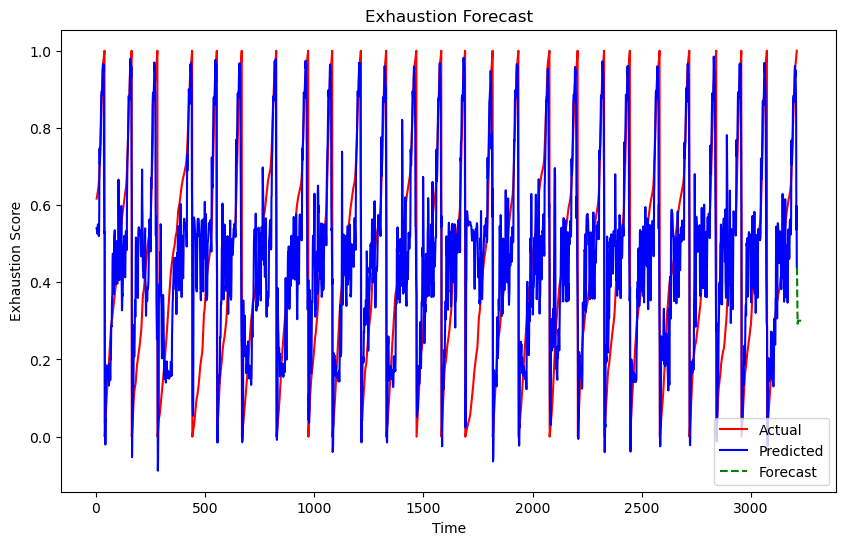

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


INFO: Saved model summary dataframe to ../../data/Deep_Learning_Final/model_summary.csv


=== Model Summaries ===
              Model            Type       MSE       MAE  R2 Score  Accuracy  \
0  Exhaustion Model      Regression  0.028506  0.118872   0.60818       NaN   
1      Injury Model  Classification       NaN       NaN       NaN  0.718877   

   Precision    Recall  F1 Score  
0        NaN       NaN       NaN  
1   0.739048  0.703748  0.720966  


In [79]:
# %%writefile src/main.py
"""
Main entry point for running the entire pipeline.
"""

import sys
import os
import logging
# from data_loading import load_data
# from advanced_features import prepare_joint_features, compute_aggregated_features, compute_injury_risk
# from preprocessing import temporal_train_test_split
# from training import train_exhaustion_model, train_injury_model, train_joint_models
# from inference import forecast_and_plot_exhaustion
# from results import summarize_exhaustion_model, summarize_classification_model, summarize_all_models

# Set logging configuration
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')


if __name__ == "__main__":
    # File paths (update as needed)
    csv_path = "../../data/processed/final_granular_dataset.csv"
    json_path = "../../data/basketball/freethrow/participant_information.json"
    output_summary = "../../data/Deep_Learning_Final/model_summary.csv"
    
    # Data loading and basic feature preparation
    data = load_data(csv_path, json_path, debug=True)
    
    # Update joint features (includes joint angles, power ratios, and ROM)
    data = prepare_joint_features(data, debug=True)
    
    # Additional feature engineering steps
    data = compute_aggregated_features(data, debug=True)
    
    # Compute injury risk if missing
    data = compute_injury_risk(data, debug=True)
    data = feature_engineering(data, debug=True)
    # Preprocessing: train-test split
    train_data, test_data = temporal_train_test_split(data, test_size=0.2)
    
    # Define features for training (ensure these columns now exist)
    features_exhaustion = ['joint_power', 'joint_energy', 'time_since_start']
    features_injury = features_exhaustion  # or different features for injury risk
    timesteps = 5  # For LSTM sequence generation
    
    # Train exhaustion and injury models
    model_exh, scaler_exh, target_scaler, X_val_exh, y_val_exh = train_exhaustion_model(
        train_data, test_data, features_exhaustion, timesteps, epochs=50, batch_size=32
    )
    model_injury, scaler_injury, X_val_injury, y_val_injury = train_injury_model(
        train_data, test_data, features_injury, timesteps, epochs=50, batch_size=32
    )
    
    # Train joint-specific models
    joints = ['ANKLE', 'WRIST', 'ELBOW', 'KNEE', 'HIP']
    joint_models = train_joint_models(
        train_data, test_data, joints=joints, timesteps=timesteps, features_dir="../../data/Deep_Learning_Final",
        epochs=50, batch_size=32
    )
    
    # Forecast and plot for exhaustion as an example
    forecast_and_plot_exhaustion(
        model=model_exh,
        test_data=test_data,
        forecast_features=features_exhaustion,
        scaler_exhaustion=scaler_exh,
        target_scaler=target_scaler,
        timesteps=timesteps,
        future_steps=20,
        title="Exhaustion Forecast"
    )
    
    # Get evaluation results and save summary
    exh_metrics = summarize_exhaustion_model(model_exh, X_val_exh, y_val_exh, target_scaler)
    inj_metrics = summarize_classification_model(model_injury, X_val_injury, y_val_injury)
    joint_metrics = []  # Optionally, add metrics for joint models
    
    summary_df = summarize_all_models(exh_metrics, inj_metrics, joint_metrics, output_summary)
    print("=== Model Summaries ===")
    print(summary_df)

